# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%%bash
pip install ../optionlib

Processing /Users/dwynne891/Documents/Options/optionlib
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for optionlib: filename=optionlib-0.1.0-py3-none-any.whl size=44365 sha256=1b44e960429018d25a2278622d102ffd998f6289201d87ece72c65d7eb1d4aa1
  Stored in directory: /private/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/pip-ephem-wheel-cache-3e5f0wuj/wheels/4d/62/1f/11cc5573a52206189c39d7fffa7bb24e2fafc7df16a30a71e1
Successfully built optionlib
  Attempting uninstall: optionlib
    Found existing installation: optionlib 0.1.0
    Uninstalling optionlib-0.1.0:
      Successfully uninstalled optionlib-0.1.0


In [4]:
import requests as r
import pandas as pd
from datetime import datetime
import numpy as np
import plotly.express as px
import pytz

In [5]:

from optionlib import floating_quantile, menus, options
from optionlib.data import prices

# Load data

In [7]:
# Load historical data

eth_prices = pd.read_parquet('price_history/trade_data_cleaned.parquet')

eth_prices = eth_prices.reset_index().assign(
    bucket = lambda x: x.timestamp.dt.ceil("H"),
    DTE = lambda x: x.expiration - x.bucket,
    strike_dist = lambda x: abs(x.strike - x.index_price),
    index_return = lambda x: (x.delivery_price/x.index_price) - 1,
    abs_index_return = lambda x: x.index_return.abs()
)

In [8]:
# IV by DTE
iv_by_dte = pd.read_parquet('price_history/iv_by_dte.parquet')

# Query data

In [95]:
# Option prices

currency = 'ETH'
kind = 'option'
url = f'https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency={currency}&kind={kind}'

response = r.get(url)
df_prices_raw = pd.DataFrame.from_dict(response.json()['result'])


In [96]:
# Instrument details

url = f'https://www.deribit.com/api/v2/public/get_instruments?currency={currency}&kind={kind}'

response = r.get(url)
df_instruments = pd.DataFrame.from_dict(response.json()['result'])

In [97]:
# Merge prices and instruments

keep_cols_prices = [
    'mark_iv',
    'ask_price',
    'bid_price',
    'mark_price',
    'estimated_delivery_price'
]

instruments_keep_cols = [
    'option_type',
    'strike',
    'expiration_timestamp',
]

df_prices = df_prices_raw.set_index('instrument_name')[keep_cols_prices]

df_prices = df_prices.join(
    df_instruments.set_index('instrument_name')[instruments_keep_cols]
).assign(
    expiration_timestamp = lambda x: pd.to_datetime(
        x.expiration_timestamp,
        unit = 'ms',
        utc=True
    ),
    DTE = lambda x: (x.expiration_timestamp - datetime.now(tz=pytz.UTC)).dt.ceil('H'),
    put_call = lambda x: x.option_type.str[0].str.upper(),
    strike_dist = lambda x: (x.estimated_delivery_price - x.strike).abs()
).rename(columns = {
    'ask_price':'Ask',
    'bid_price':'Bid',
    'mark_price':'Midpoint',
    'mark_iv':'IV',
    'strike':'Strike'
}).set_index(['put_call','Strike'],append = True)

# Floating quintile

In [102]:
df_prices_closest = df_prices.loc[
    df_prices.groupby(
        ['expiration_timestamp','option_type']
    ).strike_dist.idxmin()
]

asset_price = df_prices_closest.estimated_delivery_price.mode()[0]
DTE_options = df_prices_closest.DTE.unique()

print(
    'DTE options:\n',
    DTE_options
)

DTE options:
 <TimedeltaArray>
[  '0 days 06:00:00',   '1 days 06:00:00',   '2 days 06:00:00',
   '6 days 06:00:00',  '13 days 06:00:00',  '20 days 06:00:00',
  '41 days 06:00:00',  '55 days 06:00:00',  '76 days 06:00:00',
 '104 days 06:00:00', '195 days 06:00:00', '286 days 06:00:00']
Length: 12, dtype: timedelta64[ns]


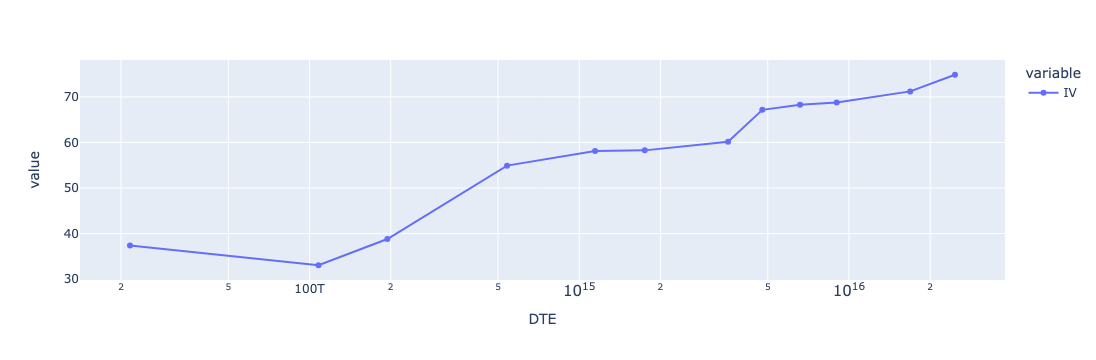

In [104]:
px.line(
    df_prices_closest.groupby('DTE').IV.mean(),
    markers= 'o',
    log_x = True,
    #hover_data = DTE_options
)

In [106]:
# Pick DTE index from array above

DTE = DTE_options[3]

iv = df_prices_closest.loc[
    df_prices_closest.DTE.eq(DTE),
    'IV'
].mean()

#iv = 50

print(DTE,iv)

6 days 06:00:00 54.91


In [108]:
ntile = 4

df_prices_dte_filter = iv_by_dte.loc[
    eth_prices.DTE.eq(DTE)
].sort_values('iv')

caliper = round(df_prices_dte_filter.shape[0]/(ntile*2))



In [110]:
df_prices_dte_filter.sort_values('iv',inplace = True)

qtile_df_low = df_prices_dte_filter.where(
    lambda x: x['iv'].lt(iv)
).dropna().tail(caliper)

qtile_df_hi = df_prices_dte_filter.where(
    lambda x: x['iv'].gt(iv)
).dropna().head(caliper)

floating_quintile = pd.concat(
    [qtile_df_low,qtile_df_hi]
).index_return.quantile([round(i,2) for i in np.linspace(0.01,.99,99)])

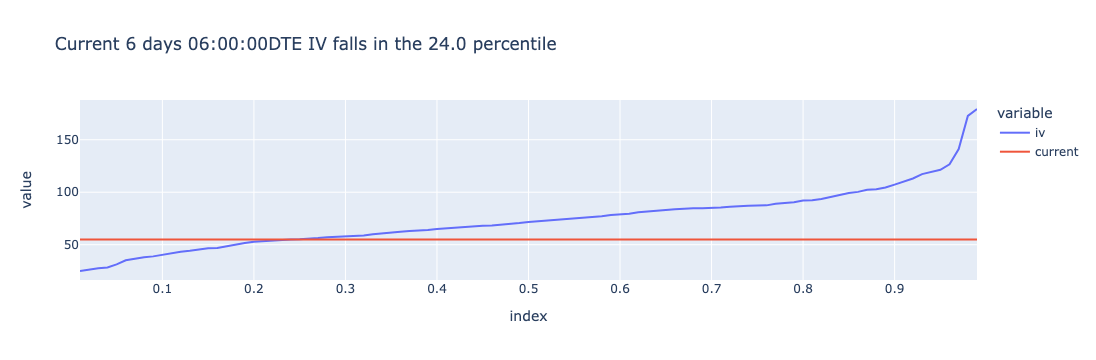

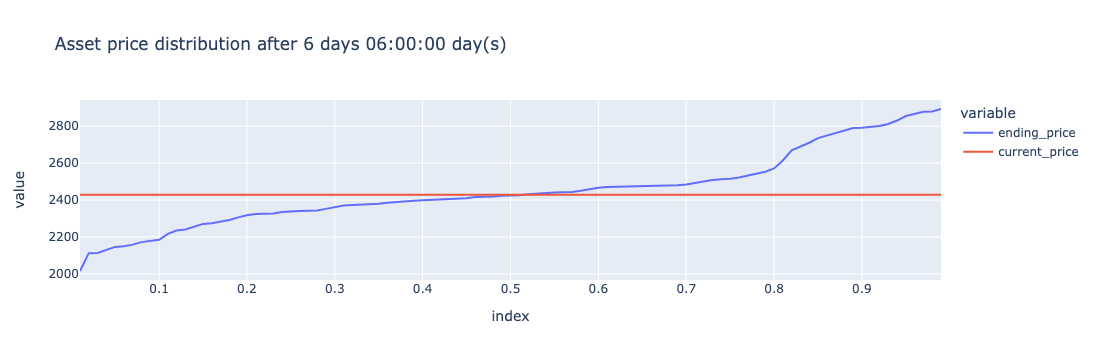

In [112]:
IV_ptiles = df_prices_dte_filter.iv.quantile(
        [round(i,2) for i in np.linspace(0.01,.99,99)]
).to_frame()

IV_ptile_current = (IV_ptiles - iv).abs().idxmin().values[0]

px.line(
    IV_ptiles.assign(current = iv),
    title = f'Current {DTE}DTE IV falls in the {round(IV_ptile_current*100,0)} percentile'
).show()

plot_df = floating_quintile.to_frame().assign(
    last_close = asset_price,
    pct_return = lambda x: round(x.index_return*100,2),
    ending_price = lambda x: x.index_return.add(1).multiply(asset_price),
    current_price = asset_price
)

px.line(
    plot_df,
    y = ['ending_price','current_price'],
    hover_data = ['pct_return'],
    title = f'Asset price distribution after {DTE} day(s)'
).show()

# Valuation

In [115]:
currency_vars = ['Bid','Ask','Midpoint']

df_prices_dte = df_prices.loc[
    df_prices.DTE.eq(DTE),
    currency_vars + ['IV']
].droplevel('instrument_name').sort_index().dropna()

df_prices_dte[currency_vars] = df_prices_dte[currency_vars] * asset_price

In [117]:
bounds = tuple(round(i) for i in floating_quintile.agg(['min','max']).add(1).multiply(asset_price))
print(bounds)

menu = menus.TradeMenu(
    df_prices_dte,
    asset_price,
    floating_quintile,
    bounds = bounds,
    midpoint_price = True,
    contract_size = 1
)

(2016, 2893)


## Iron Condors

In [120]:
max_combos = 10_000

menu.iron_condors(
#        downsample = max_combos,
        win_pct_bounds = (0,1)
)

Calculating 335 Iron Condors...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 335 out of 335 | elapsed:    0.9s finished


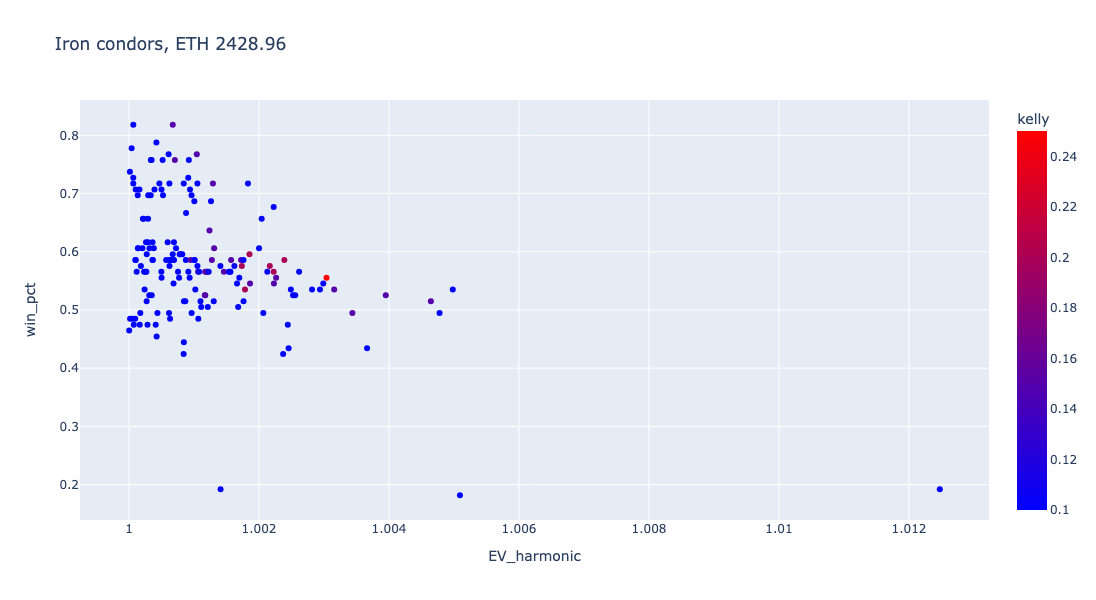

In [122]:
px.scatter(
    data_frame = menu.menu.loc['Iron condor'].reset_index(),#.sample(30000),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['leg_1','leg_2','leg_3','leg_4'],
    title = f'Iron condors, ETH {asset_price}',
    #opacity = 0.5,
    height = 600,
    color = 'kelly',
    color_continuous_scale=px.colors.sequential.Bluered
)

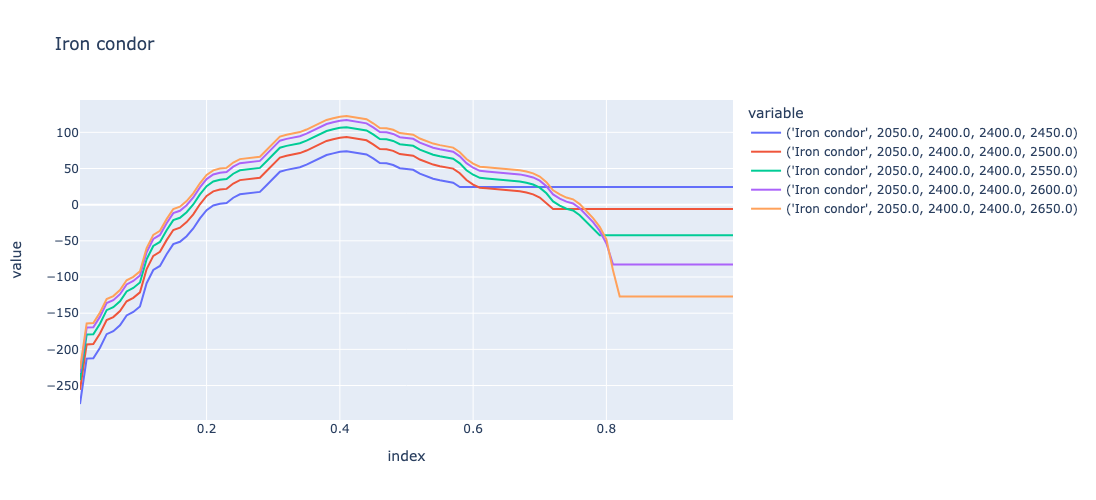

In [146]:
strategy = 'Iron condor'
val1, val2, val3, val4 = 2050,2400,2400,2550
menu_slice = menu.menu_quantiles.loc[pd.IndexSlice[strategy,val1,val2,val3,:],:].T

menu_slice.columns = [str(i) for i in menu_slice.columns.to_flat_index()]

plot_df = menu_slice.copy()

px.line(plot_df,height = 500,title = strategy)

In [126]:
menu.menu.loc[pd.IndexSlice[strategy,val1,val2,val3,val4],:]

KeyError: ('Iron condor', 2000, 2350, 2350, 2400)

In [ ]:
menu.menu.loc[pd.IndexSlice[strategy,val1,val2,val3,val4],'cost']/asset_price

In [127]:
asset_price

2428.96

## Long strategies 

In [132]:
menu.long_all()

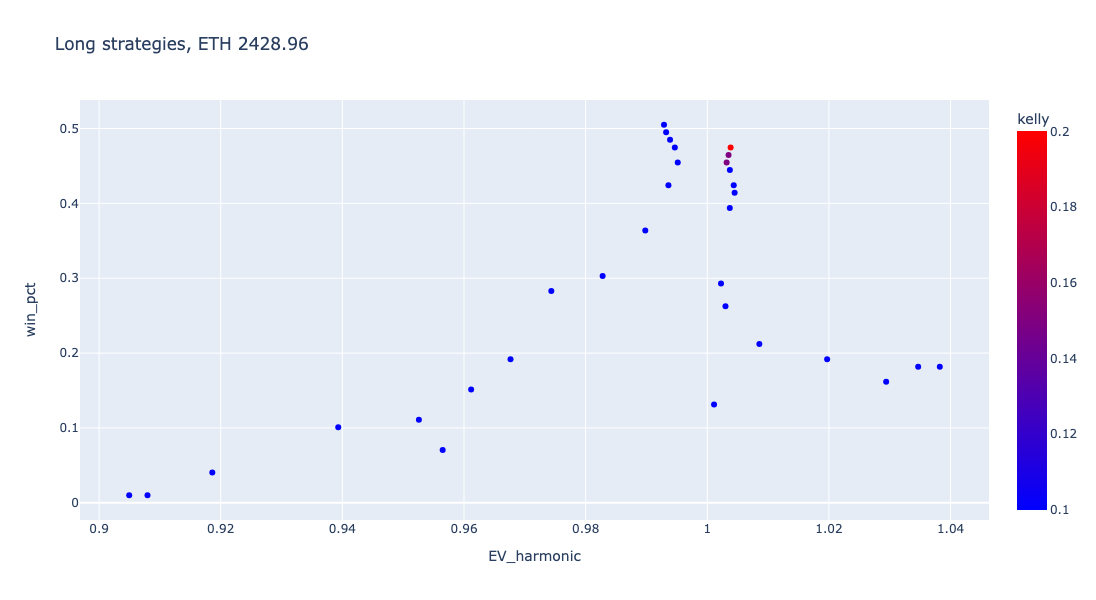

In [134]:
px.scatter(
    data_frame = menu.menu.loc[['Long calls','Long puts']].reset_index(),#.sample(30000),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['strategy','leg_1'],
    title = f'Long strategies, ETH {asset_price}',
    #opacity = 0.5,
    height = 600,
    color = 'kelly',
    color_continuous_scale=px.colors.sequential.Bluered
)

## Spreads

In [137]:
menu.spreads()

Calculating bull call spreads ...
Calculating bull put spreads ...
Calculating bear call spreads ...
Calculating bear put spreads ...
Complete


## Straddles/strangles

In [139]:
menu.long_strangle()

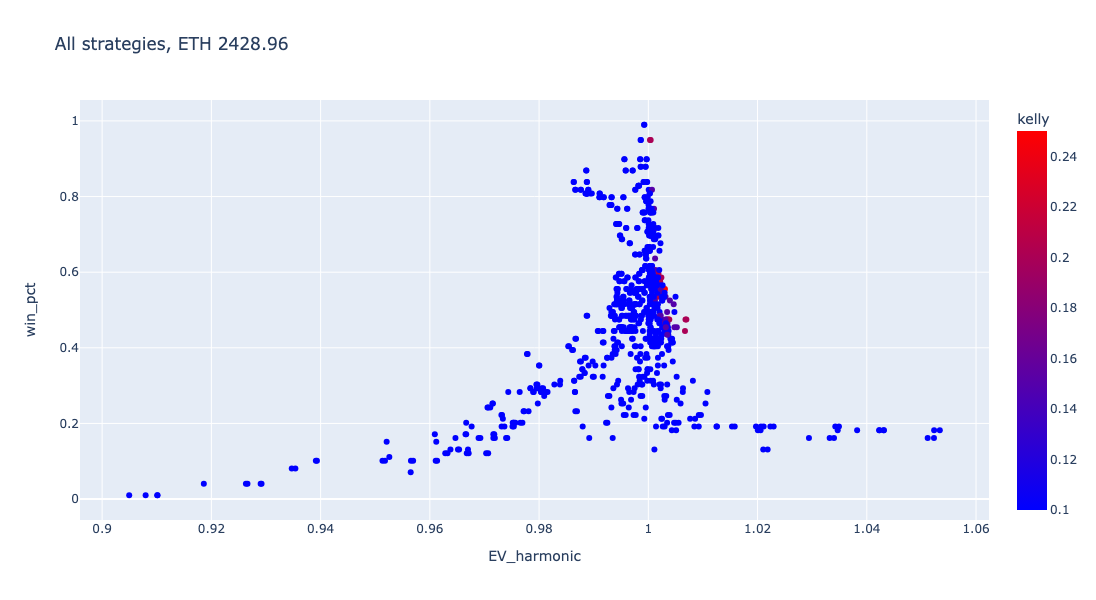

In [142]:
px.scatter(
    data_frame = menu.menu.reset_index(),#.sample(30000),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['strategy','leg_1','leg_2'],
    opacity = 1,
    height = 600,
    color = 'kelly',
    color_continuous_scale=px.colors.sequential.Bluered,
    title = f'All strategies, ETH {asset_price}'
)

In [144]:
strategy = 'Bull call spread'
val1, val2=2000,2250
menu_slice = menu.menu_quantiles.loc[pd.IndexSlice[strategy,val1,:],:].T

menu_slice.columns = [str(i) for i in menu_slice.columns.to_flat_index()]

px.line(menu_slice,height = 500,title = strategy)

KeyError: 2000

In [218]:
menu.menu.loc[pd.IndexSlice[strategy,val1,val2,:,:],:]

,,,,,cost,EV_arithmetic,win_pct,max_loss,EV_harmonic,kelly
strategy,leg_1,leg_2,leg_3,leg_4,,,,,,
Bull call spread,2200.0,2600.0,NaN,NaN,318.716107,19.780413,0.767677,-320.016107,1.014673,0.45


# Kelly criteria

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.5s finished


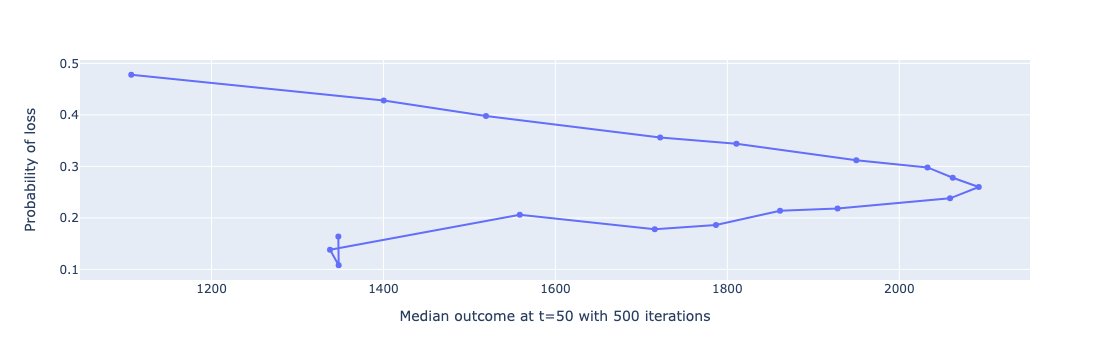

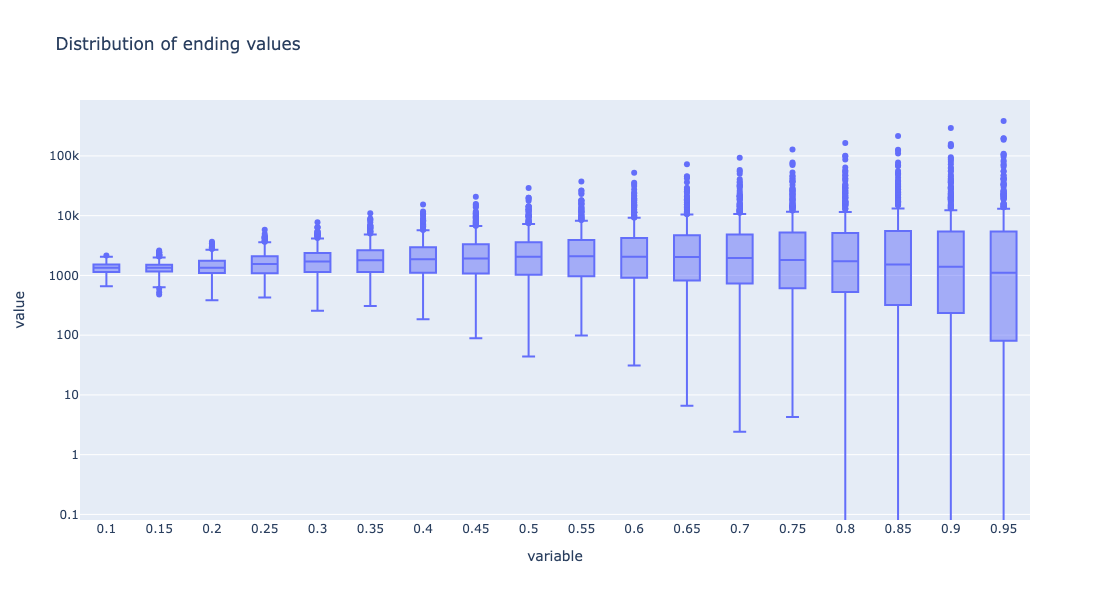

       Contracts    Max_loss  Max_gain
Kelly                                 
0.10         0.0   -0.000000      0.00
0.15         0.0   -0.000000      0.00
0.20         1.0 -160.450638     39.55
0.25         1.0 -160.450638     39.55
0.30         1.0 -160.450638     39.55
0.35         2.0 -320.901276     79.10
0.40         2.0 -320.901276     79.10
0.45         2.0 -320.901276     79.10
0.50         3.0 -481.351914    118.65
0.55         3.0 -481.351914    118.65
0.60         3.0 -481.351914    118.65
0.65         4.0 -641.802553    158.20
0.70         4.0 -641.802553    158.20
0.75         4.0 -641.802553    158.20
0.80         4.0 -641.802553    158.20
0.85         5.0 -802.253191    197.75
0.90         5.0 -802.253191    197.75
0.95         5.0 -802.253191    197.75


In [88]:
strategy = 'Iron condor'
#val1, val2, val3, val4 =4940,4985,5080,5090

#strategy = 'Bear put spread'
#val1, val2=3500,2900

menu.kelly_criteria(strategy, val1, val2, val3, val4,iterations = 500,bankroll = 1000)

# Analysis

In [376]:
trades = pd.read_parquet('price_history/trade_data_cleaned.parquet').reset_index()

trades = trades.assign(
    timestamp_est = lambda x: pd.DatetimeIndex(x.timestamp,tz='UTC').tz_convert('US/Eastern')
)

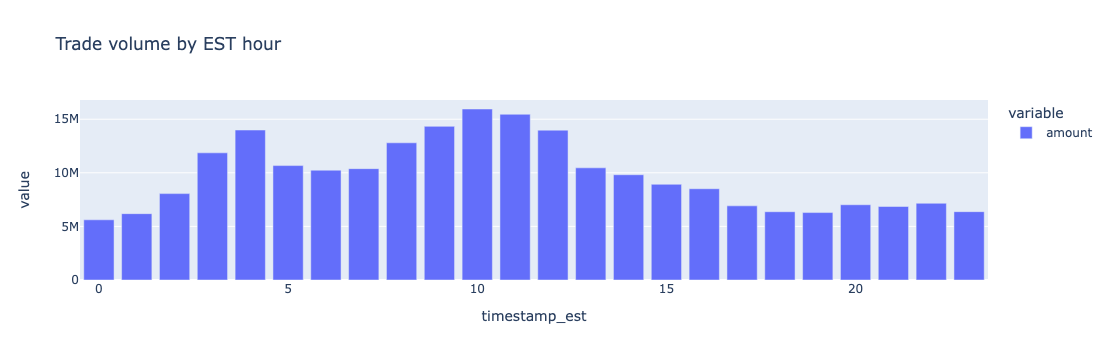

In [434]:
px.bar(
    trades.groupby(
        trades.timestamp_est.dt.hour
    ).amount.sum(),
    title = 'Trade volume by EST hour'
)

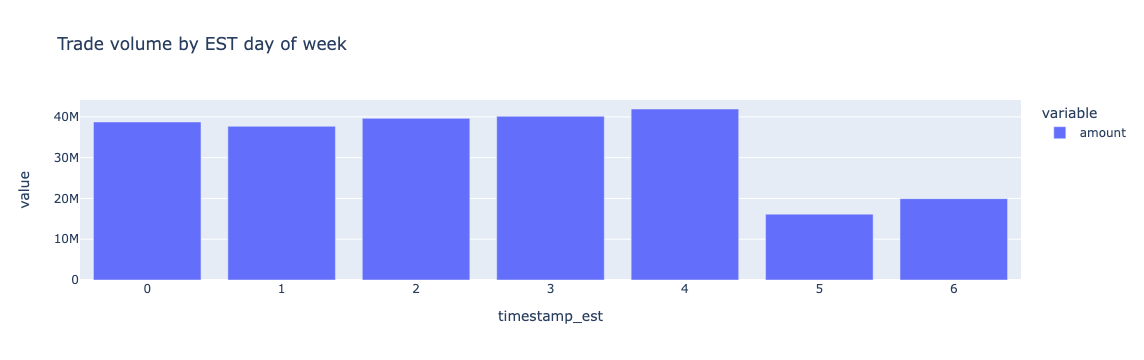

In [436]:
px.bar(
    trades.groupby(
        trades.timestamp_est.dt.day_of_week
    ).amount.sum(),
    title = 'Trade volume by EST day of week'
)